# Installing GDAL

In [ ]:
!apt-get update
!apt-get install libgdal-dev -y
!apt-get install python-gdal -y
!apt-get install python-numpy python-scipy -y
!pip install rasterio
import gdal 

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:12 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Get:13 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [854 kB]
Get:14 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic/main 

# Importing Libraries

In [ ]:
from tqdm.autonotebook import tqdm
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import rasterio
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

print("TF version:", tf.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  """Entry point for launching an IPython kernel.


TF version: 2.2.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available


# Copying over data from Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!cp "/content/drive/Shared drives/SIO and E4E Mangroves /Data/Visualizations/Orthos 5.22.20/Orto_Puerto_Gata_Tiles.zip" .
!ls

drive  Orto_Puerto_Gata_Tiles.zip  sample_data


In [ ]:
!rm -rf /content/images/images/

In [ ]:
!unzip Orto_Puerto_Gata_Tiles.zip
!mkdir /content/images
!mkdir /content/images/images
!mv *.tif /content/images/images/

Archive:  Orto_Puerto_Gata_Tiles.zip
  inflating: Orto_Puerto_Gata_01_19.tif  
  inflating: Orto_Puerto_Gata_01_20.tif  
  inflating: Orto_Puerto_Gata_01_21.tif  
  inflating: Orto_Puerto_Gata_02_19.tif  
  inflating: Orto_Puerto_Gata_02_20.tif  
  inflating: Orto_Puerto_Gata_02_21.tif  
  inflating: Orto_Puerto_Gata_02_22.tif  
  inflating: Orto_Puerto_Gata_02_23.tif  
  inflating: Orto_Puerto_Gata_02_24.tif  
  inflating: Orto_Puerto_Gata_02_25.tif  
  inflating: Orto_Puerto_Gata_03_16.tif  
  inflating: Orto_Puerto_Gata_03_17.tif  
  inflating: Orto_Puerto_Gata_03_19.tif  
  inflating: Orto_Puerto_Gata_03_20.tif  
  inflating: Orto_Puerto_Gata_03_21.tif  
  inflating: Orto_Puerto_Gata_03_22.tif  
  inflating: Orto_Puerto_Gata_03_23.tif  
  inflating: Orto_Puerto_Gata_03_24.tif  
  inflating: Orto_Puerto_Gata_03_25.tif  
  inflating: Orto_Puerto_Gata_03_26.tif  
  inflating: Orto_Puerto_Gata_03_27.tif  
  inflating: Orto_Puerto_Gata_03_28.tif  
  inflating: Orto_Puerto_Gata_03_29.tif

In [ ]:
#downloading model file
!cp "/content/drive/Shared drives/SIO and E4E Mangroves /Data/Machine Learning/Models/mvnmv4_merced_bright.zip" .
!unzip mvnmv4_merced_bright.zip

Archive:  mvnmv4_merced_bright.zip
   creating: mvnmv4_merced/
   creating: mvnmv4_merced/assets/
   creating: mvnmv4_merced/variables/
  inflating: mvnmv4_merced/variables/variables.index  
  inflating: mvnmv4_merced/variables/variables.data-00001-of-00002  
  inflating: mvnmv4_merced/variables/variables.data-00000-of-00002  
  inflating: mvnmv4_merced/saved_model.pb  


# Classification Parameters

In [ ]:
from tensorflow.keras.models import load_model

#Set model location
output_file = "results.csv"
model = "/content/mvnmv4_merced/"
image_directory = "/content/images"

model = load_model(model)

# Classifying Images

In [ ]:
#Read images using keras and split into batches
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
data_gen = image_generator.flow_from_directory(directory=image_directory,
                                                     batch_size=32,
                                                     shuffle=False,
                                                     target_size=(256, 256))

Found 2923 images belonging to 1 classes.


In [ ]:

#Set up dataframe that will hold classifications
column_names = ["prediction","filename"]
result_df = pd.DataFrame(columns=column_names)

#predict probabilities from model for the batches
predictions = model.predict(data_gen)

#associate filenames and classification for each prediction
for i,prediction in tqdm(enumerate(predictions)):
    result_df.loc[i,"filename"] = data_gen.filenames[i]
    result_df.loc[i,"prediction"] = np.argmax(prediction)

In [ ]:
dest_folders = []
#Organize tiles into folders
for index, row in tqdm(result_df.iterrows()):
	cur_file = "/content/images/" + row['filename']
	cur_file = cur_file.replace("jpg","tif",2)
	classification = row['prediction'] 

    #set destination folder, and creates the folder if it doesn't exist
	dest_folder = os.path.join(os.path.abspath(image_directory),str(classification))
	dest_folders.append(dest_folder)
	if os.path.exists(dest_folder) == False:
		os.mkdir(dest_folder)
	dest = os.path.join(dest_folder,os.path.basename(cur_file))
 
    #moves file
	src = cur_file
	os.rename(src, dest)

# Visualization and uploading data to drive

In [ ]:
#recombines classified tiles for each class
!gdal_merge.py -o /content/1.tif /content/images/1/*
!gdal_merge.py -o /content/0.tif /content/images/0/*

0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


In [ ]:
#copies orthomosaics generated to the drive
!cp "/content/1.tif" "/content/drive/Shared drives/SIO and E4E Mangroves /Data/Visualizations/Orthos 5.22.20/Orto_Puerto_Gatanm_v4bright.tif"
!cp "/content/0.tif" "/content/drive/Shared drives/SIO and E4E Mangroves /Data/Visualizations/Orthos 5.22.20/Orto_Puerto_Gatam_v4bright.tif"

CAUTION: Keep in mind that these will crash your instance if the orthmosaics are above ~2GB, so please be careful with the file sizes!


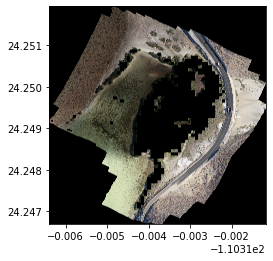

In [ ]:
from rasterio.plot import show
src = rasterio.open("1.tif")
rasterio.plot.show(src)

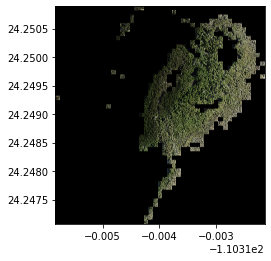

In [ ]:
src = rasterio.open("0.tif")
show(src)